
## Loading dependencies

Not really interesting to comments in this part, but obviously required.

In [1]:
# -*- coding: utf-8 -*-
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Optional, cast
import time  # Import for measuring training time
from torchinfo import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.sparse import spmatrix
import numpy as np

# Get current notebook path
# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
project_root = notebook_path.parent.parent
sys.path.insert(0, str(project_root))

from scripts.dataLoading import data_3cl, spectral_cols


## Metrics & reusable functions

We define what will be our metrics, for both regression and classification task. We add the epoch_time, which will serve us to have an understandment of the "cost" of the learning. We factorise the plot and metrics across all projects

In [2]:
from src.metrics import (
    ClassificationMetrics,
    RegressionMetrics,
    plot_regression_metrics_sequence,
    print_regression_metrics,
    plot_classification_metrics_sequence,
    print_classification_metrics,
    plot_classification_metrics
)


## Common Parameters

For the ease of trying other combination of hyperparameters, we put some value as constants. The impact of the batch size and the learning rate are very significant : try to play with those value !

In [3]:
# ==============================================================================
# CONFIGURABLE PARAMETERS
# ==============================================================================
# Number of training epochs
N_MAX_EPOCHS = 200
# Random seed for reproducibility
RANDOM_SEED = 42
# Batch size for training
BATCH_SIZE = 32
# Learning rate for the optimizer
LEARNING_RATE = 0.0001
# Proportion of data for the test set
TEST_SIZE = 0.25
# Proportion of data for the validation set (relative to remaining data)
VAL_SIZE = 0.2
# ==============================================================================

# Perceptron without Data augmentation

We will start to inspect the perceptron model, using the raw dataset, for both calssification and regression tasks.

The code used here is shared in a 3 python files and you should run it yourself with various hyperparmeters to see how it impacts the metrics !

Namely, it is in :
- scripts\neural_networks\perceptron.py: Perceptron on both task, using raw data
- scripts\neural_networks\perceptron_regression_augmented.py: Using an augmention technique to balance the classe, for the regression task 
- scripts\neural_networks\perceptron_classification_augmented.py: Using an augmention technique to balance the classe, for the classification task 


## Regression

This is our model, the definition of our perceptron implementation. 

It is only composed of a single neuron in the case of the regresion.

In [6]:
# Simple Perceptron model (one dense layer)
class Perceptron(nn.Module):
    """Single layer perceptron for regression

    Args:
        input_dim: Number of input features
        output_dim: Number of outputs (1 for single value regression)
    """

    def __init__(self, input_dim: int, output_dim: int = 1):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


# Custom Dataset class for our spectral data
class SpectralDataset(Dataset):
    """Simple Dataset class to handle spectral data for PyTorch"""

    def __init__(self, X: np.ndarray | spmatrix, y: np.ndarray | spmatrix):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


### Data preparation

In [6]:

# Preparing data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    data_3cl[spectral_cols],
    data_3cl[["Chl", "num_classe"]],
    test_size=TEST_SIZE,
    random_state= RANDOM_SEED,
)

# Split remaining data into train and validation sets
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_reg, y_train_reg, test_size=VAL_SIZE, random_state= RANDOM_SEED
)

# Standardize features for regression
scaler_X_reg = StandardScaler()
scaler_y_Chl = StandardScaler()

X_train_reg = scaler_X_reg.fit_transform(X_train_reg)
X_val_reg = scaler_X_reg.transform(X_val_reg)
X_test_reg = scaler_X_reg.transform(X_test_reg)

y_train_chl = scaler_y_Chl.fit_transform(y_train_reg["Chl"].values.reshape(-1, 1))
y_val_chl = scaler_y_Chl.transform(y_val_reg["Chl"].values.reshape(-1, 1))
y_test_chl = scaler_y_Chl.transform(y_test_reg["Chl"].values.reshape(-1, 1))
# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_reg, y_train_chl)
val_dataset = SpectralDataset(X_val_reg, y_val_chl)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### Model, criterion and optimizer

We set up the loss function, used to give a measure of our error : here it is the mean squared error.

We also setup the retro-propagation graident algorithm, specifying which parmeters it should retropropagate (not all layer are to be "learned"), also specfying one very important hyperparameter which is the learning rate. The learning rate is a scalar multiplying the criterion: given the direction of the error, we will "climb back" in the opposite direction, but how much we go in this direction depends of the learning rate. If we set it too little, we will not moove fast enough, so the convergeance will be slow, but strudy. On the contrary, if we set it too high, we risk to jump through optimal solution, wich will have as a consequence to also slowly converge, as the weight of the various layers will "jump" from a non optimal value to another.

In [7]:

# Initialize model, loss function and optimizer
model = Perceptron(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model)

Layer (type:depth-idx)                   Param #
Perceptron                               --
├─Linear: 1-1                            203
Total params: 203
Trainable params: 203
Non-trainable params: 0

### Main training loop

We setup the maximum epoch number, we store the best model, according the the validity dataset, to use it on the final test dataset.

In [8]:
# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history_classification: List[RegressionMetrics] = []

print("Starting perceptron training...")
total_training_start = time.time()
for epoch in range(N_MAX_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Record metrics for this epoch
    metrics_history_classification.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_MAX_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_MAX_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)



# Evaluation on test set - simplified version without DataLoader
model.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_reg)
    y_test_tensor = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model(X_test_tensor).numpy()
    test_targets = y_test_tensor.numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl.inverse_transform(test_predictions)
test_targets = scaler_y_Chl.inverse_transform(test_targets)


Starting perceptron training...
Epoch [10/200]
Train Loss: 1.1268
Val Loss: 1.2583
Epoch Time: 0.00s
--------------------------------------------------
Epoch [20/200]
Train Loss: 0.7974
Val Loss: 0.9770
Epoch Time: 0.00s
--------------------------------------------------
Epoch [30/200]
Train Loss: 0.6050
Val Loss: 0.8020
Epoch Time: 0.00s
--------------------------------------------------
Epoch [40/200]
Train Loss: 0.4792
Val Loss: 0.6791
Epoch Time: 0.00s
--------------------------------------------------
Epoch [50/200]
Train Loss: 0.3866
Val Loss: 0.5747
Epoch Time: 0.00s
--------------------------------------------------
Epoch [60/200]
Train Loss: 0.3237
Val Loss: 0.4922
Epoch Time: 0.00s
--------------------------------------------------
Epoch [70/200]
Train Loss: 0.2764
Val Loss: 0.4237
Epoch Time: 0.00s
--------------------------------------------------
Epoch [80/200]
Train Loss: 0.2436
Val Loss: 0.3705
Epoch Time: 0.01s
--------------------------------------------------
Epoch [9

### Conclusion


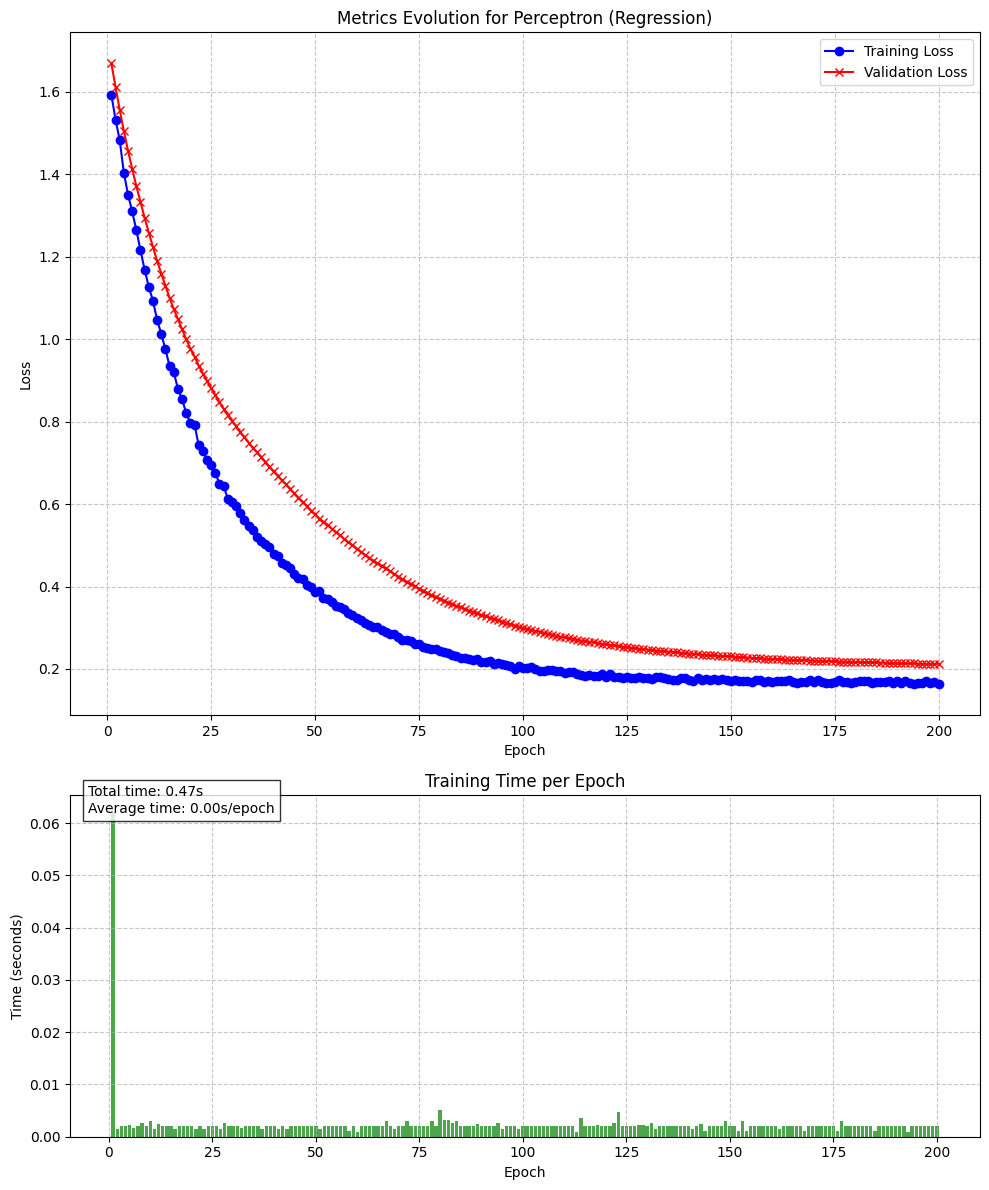


R² score on test set: 0.8597
MSE on test set: 10.2054
RMSE on test set: 3.1946
MAE on test set: 2.5583


In [9]:

# Display metrics evolution
plot_regression_metrics_sequence(
    metrics_history_classification,
    title="Metrics Evolution for Perceptron (Regression)",
)
# Display predictions vs actual values
print_regression_metrics(
    cast(np.ndarray, test_targets),
    cast(np.ndarray, test_predictions),
    set_name="test"
)



The perceptron handle nicely the regression task (comparatively to the PLS / RF algorithms). The training time is reasonable, and the learning vs validity loss function indicates that the convergeance happens early, as fast as 50 epochs, and that the training time is low (< 1 sec for 150 epochs)

## Classification

It is actually the same model that the regression one, but the naming implies taht we have a multi dimensional output corresponding to the class number we search to labeleize on.

In [7]:

# Class for the multiclass perceptron model
class MultiClassPerceptron(nn.Module):
    """Perceptron for multiclass classification

    Args:
        input_dim: Number of input features
        num_classes: Number of classes to predict
    """

    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # No need to add softmax here as CrossEntropyLoss already includes it
        return self.linear(x)


### Data preparation

In [8]:
# Encode classes with LabelEncoder for consistency
label_encoder = LabelEncoder()
# Encoding on the entire dataset before splitting
all_labels_encoded = label_encoder.fit_transform(data_3cl["num_classe"])

# Extract encoding mapping for future reference
classes = label_encoder.classes_
class_mapping = {i: cls for i, cls in enumerate(classes)}
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes.tolist()}")
print("Class index mapping:")
for idx, class_name in class_mapping.items():
    print(f"  {idx} -> {class_name}")

# Preparing data for classification
X_cls = data_3cl[spectral_cols]
y_cls = all_labels_encoded

# Split into training, validation, and test sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=TEST_SIZE, random_state = RANDOM_SEED
)

X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(
    X_train_cls, y_train_cls, test_size=VAL_SIZE, random_state= RANDOM_SEED
)

# Standardize features
scaler_X_cls = StandardScaler()
X_train_scaled = scaler_X_cls.fit_transform(X_train_cls)
X_val_scaled = scaler_X_cls.transform(X_val_cls)
X_test_scaled = scaler_X_cls.transform(X_test_cls)

# Create datasets and dataloaders
# Note: Convert to float32 for compatibility with SpectralDataset
train_dataset_cls = SpectralDataset(X_train_scaled, y_train_cls.astype(np.float32))
val_dataset_cls = SpectralDataset(X_val_scaled, y_val_cls.astype(np.float32))
test_dataset_cls = SpectralDataset(X_test_scaled, y_test_cls.astype(np.float32))

train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=BATCH_SIZE)


Number of classes: 3
Classes: [1, 2, 3]
Class index mapping:
  0 -> 1
  1 -> 2
  2 -> 3


### Model, criterion and optimizer

Remark that the main difference between the classification and regression lies in the criterion : we use here the cross entropy loss, which will **aggregate** the errors across all the labels (dimension of our MultiClassPerceptron) into a scalar.

In [9]:

# Initialize model, loss function, and optimizer
num_classes = len(classes)
model_cls = MultiClassPerceptron(input_dim=len(spectral_cols), num_classes=num_classes)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model_cls.parameters(), lr=LEARNING_RATE)
summary(model_cls)

Layer (type:depth-idx)                   Param #
MultiClassPerceptron                     --
├─Linear: 1-1                            609
Total params: 609
Trainable params: 609
Non-trainable params: 0

Notice that from the previous regression model he number of parameters is therefore mutliplied by the output dimension.

### Main training loop


Starting multiclass perceptron training...
Epoch [10/200]
Train Loss: 0.6473
Val Loss: 1.0533
Val Accuracy: 0.4839
Epoch Time: 0.02s
--------------------------------------------------
Epoch [20/200]
Train Loss: 0.6489
Val Loss: 1.0542
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------------------------------------
Epoch [30/200]
Train Loss: 0.6502
Val Loss: 1.0514
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------------------------------------
Epoch [40/200]
Train Loss: 0.6421
Val Loss: 1.0488
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------------------------------------
Epoch [50/200]
Train Loss: 0.6450
Val Loss: 1.0459
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------------------------------------
Epoch [60/200]
Train Loss: 0.6342
Val Loss: 1.0480
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------------------------------------
Epoch [70/200]
Train Loss: 0.6345
Val Loss: 1.0485
Val Accuracy: 0.4839
Epoch Time: 0.01s
--------------------

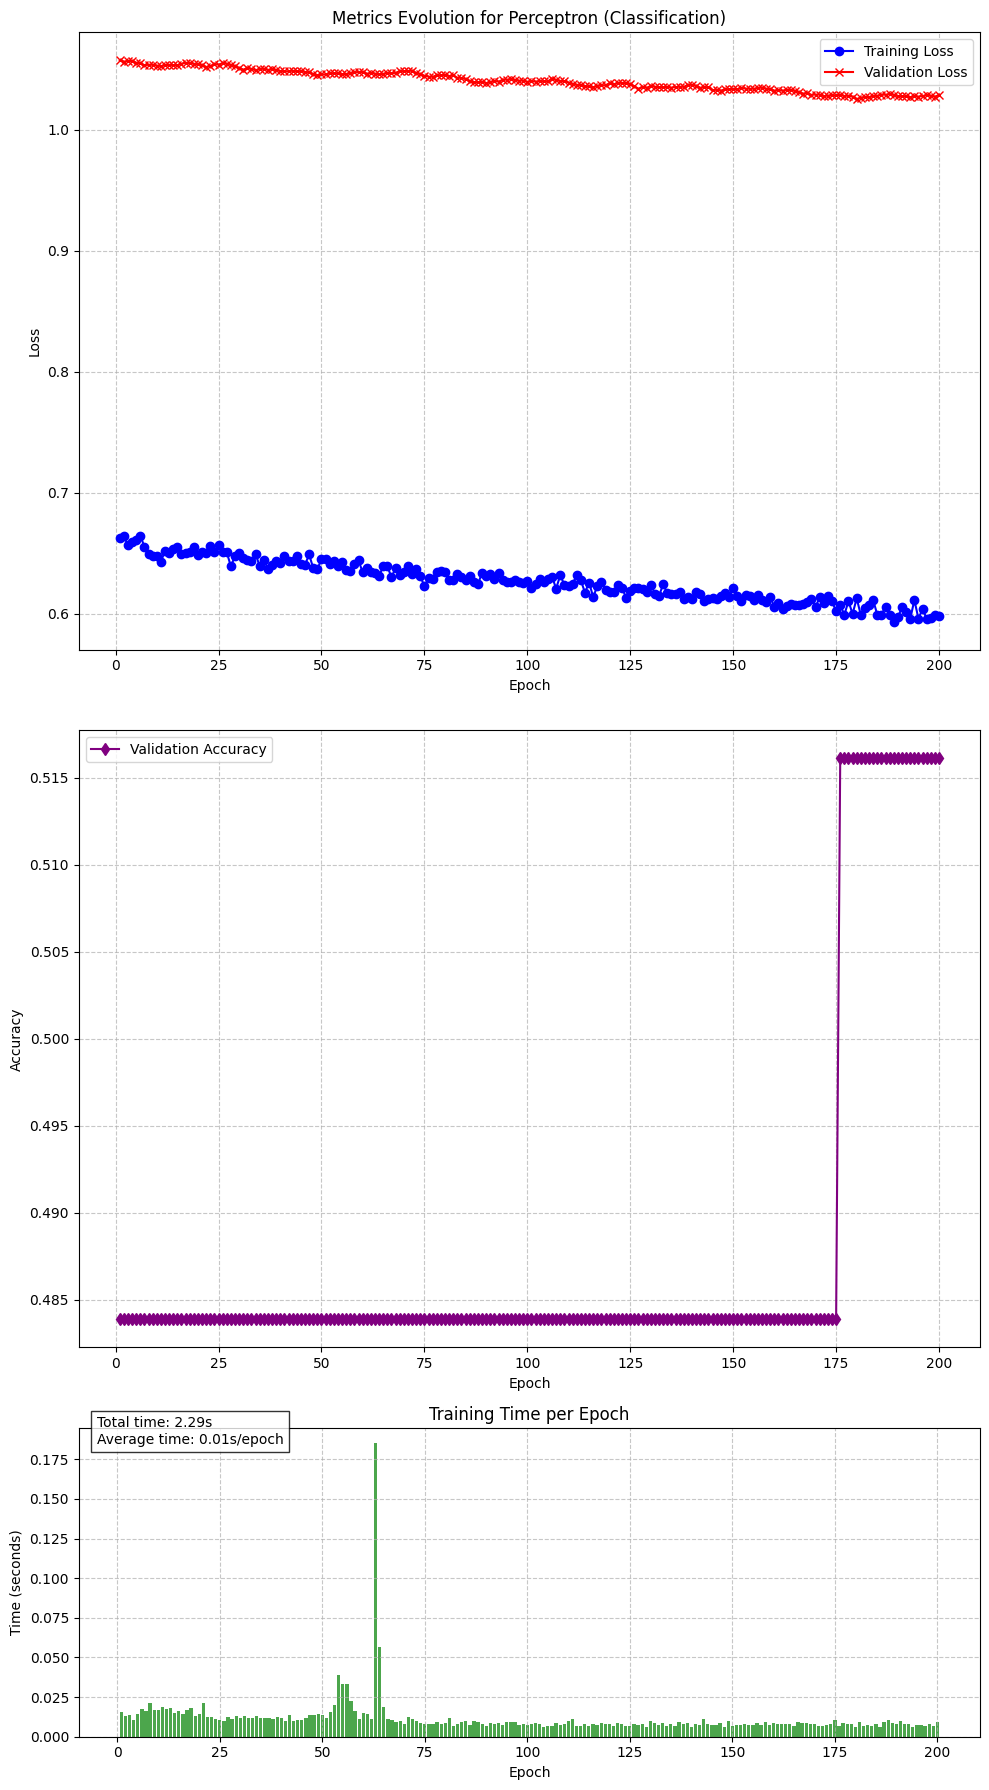

tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
        0, 0, 0, 2, 2, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2, 0, 1, 2, 2])
tensor([0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2])


In [13]:

# Training loop
best_val_loss = float("inf")
best_model = None

# List to store training metrics
metrics_history_cls: List[ClassificationMetrics] = []

print("\nStarting multiclass perceptron training...")
total_training_start = time.time()
for epoch in range(N_MAX_EPOCHS):
    epoch_start = time.time()
    # Training mode
    model_cls.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_cls:
        # Convert labels for CrossEntropyLoss
        y_batch = y_batch.long()

        optimizer_cls.zero_grad()
        outputs = model_cls(X_batch)
        loss = criterion_cls(outputs, y_batch)
        loss.backward()
        optimizer_cls.step()
        train_loss += loss.item()

    # Validation mode
    model_cls.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_cls:
            # Convert labels for CrossEntropyLoss
            y_batch = y_batch.long()

            outputs = model_cls(X_batch)
            loss = criterion_cls(outputs, y_batch)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    # Calculate average metrics
    avg_train_loss = train_loss / len(train_loader_cls)
    avg_val_loss = val_loss / len(val_loader_cls)
    val_accuracy = val_correct / val_total

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Record metrics
    metrics_history_cls.append(
        ClassificationMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_accuracy=val_accuracy,
            epoch_time=epoch_time,
        )
    )

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model_cls.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_MAX_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_MAX_EPOCHS:.2f} seconds")

# Display metrics evolution
plot_classification_metrics_sequence(
    metrics_history_cls,
    title="Metrics Evolution for Perceptron (Classification)",
)

# Load the best model for evaluation
if best_model is not None:
    model_cls.load_state_dict(best_model)
else:
    print("Warning: No best model was saved during training.")

# Evaluation on test set
model_cls.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_cls:
        # Convert labels for CrossEntropyLoss
        y_batch = y_batch.long()
        outputs = model_cls(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()
        print(y_batch)
        print(predicted)

        # Save predictions and targets for detailed metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# Calculate and display performance metrics
test_accuracy = 100 * test_correct / test_total
balanced_acc = balanced_accuracy_score(all_targets, all_predictions)
conf_matrix = confusion_matrix(all_targets, all_predictions)



### Conclusion



Metrics for test set:
Accuracy: 0.6667
Balanced Accuracy: 0.6657

Confusion Matrix:
[[23  3  7]
 [ 4  3  3]
 [ 0  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        33
           1       0.50      0.30      0.38        10
           2       0.44      1.00      0.62         8

    accuracy                           0.67        51
   macro avg       0.60      0.67      0.59        51
weighted avg       0.72      0.67      0.67        51



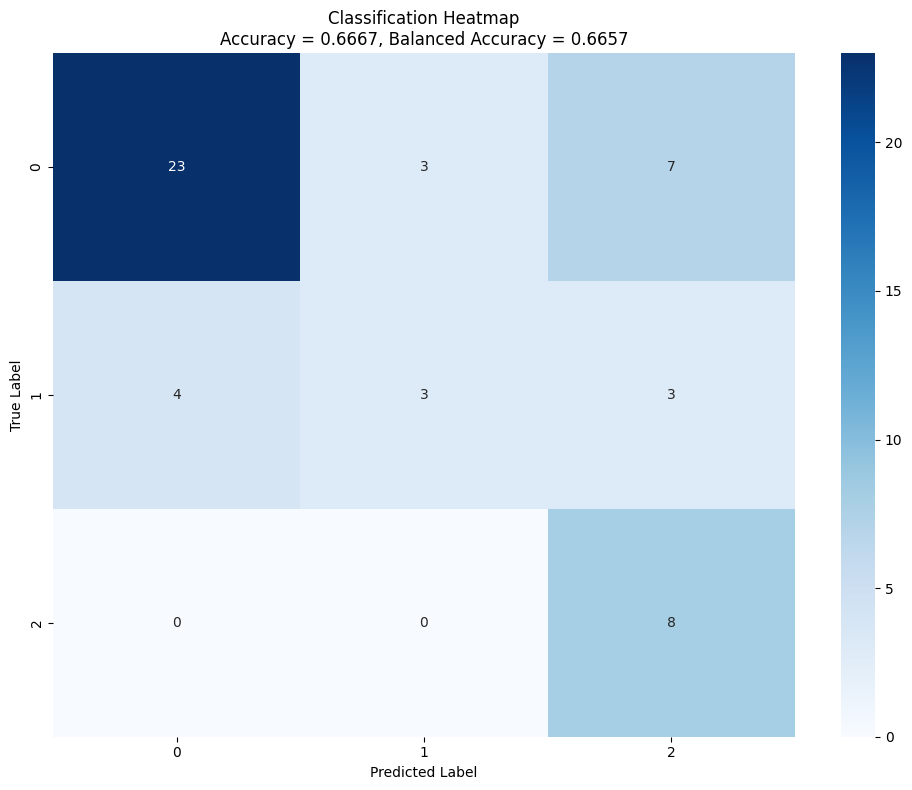

In [11]:

print_classification_metrics(all_targets, all_predictions, "test")

# Visualize confusion matrix
plot_classification_metrics(all_targets, all_predictions, "Classification Heatmap")



The perceptron is comparable to the PLS / RF algorithms, with a very reasonable timing. 

## Partial conclusion

The percptron models have slightly better, or comparable, results than the machine learning counter part, while being quite fast to provide those results, **without needing to make a pretreatment**. However, be sure to understand how some "wrong" hyperparamters can mess things up quite significantly !

# Perceptron with data augmentation 

This part explore the impact of using data augmentation to help balance the classes representation.


In [15]:
from src.data_augmenter import DataAugmenter, AugmentationParams


## Regression

### Data preparation

In [16]:

# Preparing data for regression
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test, _, _ = train_test_split(
    indices, indices, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

indices_train, indices_val, _, _ = train_test_split(
    indices_train_temp, indices_train_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED
)

# Display set sizes
print(f"Training set (original): {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets before augmentation
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=["symptom", "variety", "plotLocation"],  # Group by these columns
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (after augmentation): {len(train_data_augmented)} samples")

# Prepare features and targets for different sets
X_train_reg = np.array(train_data_augmented[spectral_cols])
y_train_reg = np.array(train_data_augmented["Chl"]).reshape(-1, 1)

X_val_reg = np.array(val_data[spectral_cols])
y_val_reg = np.array(val_data["Chl"]).reshape(-1, 1)

X_test_reg = np.array(test_data[spectral_cols])
y_test_reg = np.array(test_data["Chl"]).reshape(-1, 1)

# Standardize features for regression
scaler_X_reg = StandardScaler()
scaler_y_Chl = StandardScaler()

X_train_reg = scaler_X_reg.fit_transform(X_train_reg)
X_val_reg = scaler_X_reg.transform(X_val_reg)
X_test_reg = scaler_X_reg.transform(X_test_reg)

y_train_chl = scaler_y_Chl.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl.transform(y_val_reg)
y_test_chl = scaler_y_Chl.transform(y_test_reg)

# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_reg, y_train_chl)
val_dataset = SpectralDataset(X_val_reg, y_val_chl)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Training set (original): 122 samples
Validation set: 31 samples
Test set: 51 samples


D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

Training set (after augmentation): 3900 samples


### Model, criterion and optimizer

In [17]:

# Initialize model, loss function and optimizer
model = Perceptron(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


### Main training loop

In [18]:

# Training loop for standard model
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history_reg: List[RegressionMetrics] = []

print("Starting perceptron training for regression with standard data...")
total_training_start = time.time()
for epoch in range(N_MAX_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Record metrics for this epoch
    metrics_history_reg.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_MAX_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_MAX_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set - simplified version without DataLoader
model.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_reg)
    y_test_tensor = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model(X_test_tensor).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl.inverse_transform(test_predictions)
test_targets = scaler_y_Chl.inverse_transform(test_targets)


Starting perceptron training for regression with standard data...
Epoch [10/200]
Train Loss: 0.2422
Val Loss: 0.2553
Epoch Time: 0.06s
--------------------------------------------------
Epoch [20/200]
Train Loss: 0.1959
Val Loss: 0.2357
Epoch Time: 0.05s
--------------------------------------------------
Epoch [30/200]
Train Loss: 0.1783
Val Loss: 0.2272
Epoch Time: 0.06s
--------------------------------------------------
Epoch [40/200]
Train Loss: 0.1709
Val Loss: 0.2267
Epoch Time: 0.05s
--------------------------------------------------
Epoch [50/200]
Train Loss: 0.1682
Val Loss: 0.2208
Epoch Time: 0.05s
--------------------------------------------------
Epoch [60/200]
Train Loss: 0.1668
Val Loss: 0.2224
Epoch Time: 0.05s
--------------------------------------------------
Epoch [70/200]
Train Loss: 0.1660
Val Loss: 0.2222
Epoch Time: 0.05s
--------------------------------------------------
Epoch [80/200]
Train Loss: 0.1653
Val Loss: 0.2211
Epoch Time: 0.05s
-------------------------

### Conclusion


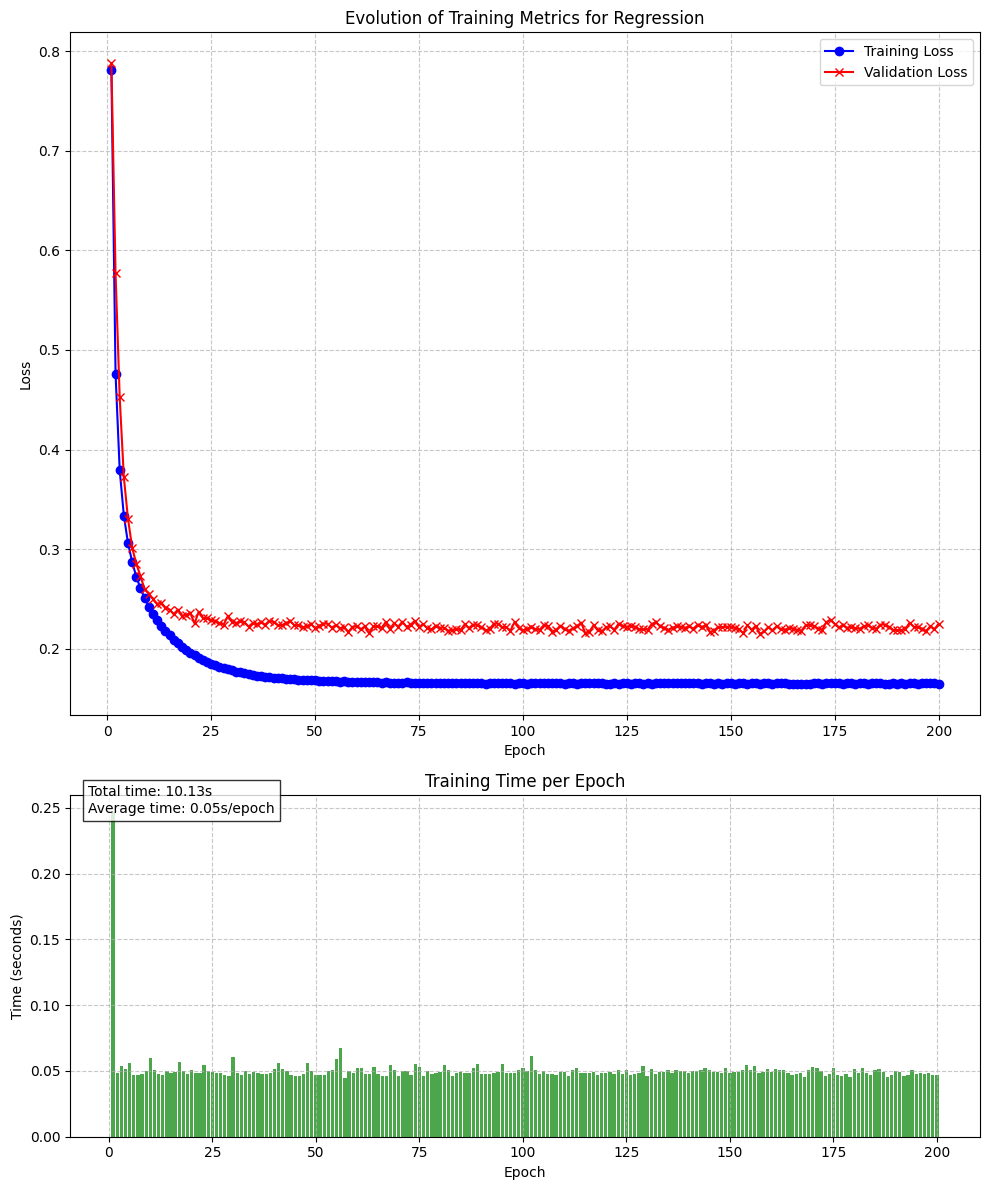


R² score on test set: 0.8445
MSE on test set: 11.3095
RMSE on test set: 3.3630
MAE on test set: 2.5278


In [19]:

# Visualize the evolution of metrics
plot_regression_metrics_sequence(
    metrics_history_reg,
    title="Evolution of Training Metrics for Regression")

print_regression_metrics(
    cast(np.ndarray, test_targets),
    cast(np.ndarray, test_predictions),
    set_name="test"
)



Here, with the chosen hyperparameters, the regression perform **worst** with the data augmentation than the simpler model, while multiplying the time to learn by 30 times. 

## Classification

### Data preparation

In [23]:
# Encoding classes with LabelEncoder for consistency
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(data_3cl["num_classe"])
all_labels_encoded = np.array(all_labels_encoded)  # Convert to numpy array explicitly

# Extract encoding mapping for future reference
classes = label_encoder.classes_
class_mapping = {i: cls for i, cls in enumerate(classes)}
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes.tolist()}")
print("Class index mapping:")
for idx, class_name in class_mapping.items():
    print(f"  {idx} -> {class_name}")

# Preparing data for classification
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test, y_train_temp, y_test_temp = train_test_split(
    indices,
    all_labels_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=all_labels_encoded,  # Ensure balanced class distribution
)

indices_train, indices_val = train_test_split(
    indices_train_temp,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    stratify=y_train_temp,  # Maintain class distribution
)

# Initial class distribution
print("\nInitial class distribution:")
for i, cls in enumerate(classes):
    count = np.sum(all_labels_encoded == i)
    print(f"Class {i} ({cls}): {count} samples")

# Display set sizes
print(f"\nTraining set (original): {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets before augmentation
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=["symptom", "num_classe", "plotLocation"],  # Group by these columns
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (after augmentation): {len(train_data_augmented)} samples")

# Prepare features and targets for different sets
X_train = np.array(train_data_augmented[spectral_cols])
y_train = np.array(label_encoder.transform(train_data_augmented["num_classe"]))

X_val = np.array(val_data[spectral_cols])
y_val = np.array(label_encoder.transform(val_data["num_classe"]))

X_test = np.array(test_data[spectral_cols])
y_test = np.array(label_encoder.transform(test_data["num_classe"]))

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Create datasets and loaders
train_dataset = SpectralDataset(X_train_scaled, y_train.astype(np.float32))
val_dataset = SpectralDataset(X_val_scaled, y_val.astype(np.float32))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Number of classes: 3
Classes: [1, 2, 3]
Class index mapping:
  0 -> 1
  1 -> 2
  2 -> 3

Initial class distribution:
Class 0 (1): 136 samples
Class 1 (2): 28 samples
Class 2 (3): 40 samples

Training set (original): 122 samples
Validation set: 31 samples
Test set: 51 samples
Training set (after augmentation): 2900 samples


D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
D:\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

### Model, criterion and optimizer

In [24]:

# Initialize model, loss function and optimizer
model = MultiClassPerceptron(input_dim=len(spectral_cols), num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


### Main training loop

In [31]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history_classification: List[ClassificationMetrics] = []

print("Starting perceptron training for classification with augmentation...")
total_training_start = time.time()
for epoch in range(N_MAX_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Convert labels to long for CrossEntropyLoss
        y_batch = y_batch.long()

        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase: evaluate model performance on validation set
    model.eval()
    # Initialize metrics
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Convert labels to long for CrossEntropyLoss
            y_batch = y_batch.long()

            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    # Calculate average metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history_classification.append(
        ClassificationMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_accuracy=val_accuracy,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_MAX_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_MAX_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    best_epoch = [m.epoch for m in metrics_history_classification if m.val_loss == best_val_loss][0]
    print(
        f"Best model loaded from epoch {best_epoch} with validation loss of {best_val_loss:.4f}"
    )

# Evaluation on test set
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)

    # Get predictions for all test data at once
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    test_total = y_test_tensor.size(0)
    test_correct = (predicted == y_test_tensor).sum().item()

    # Store predictions and targets for detailed metrics
    all_predictions = predicted.cpu().numpy()
    all_targets = y_test_tensor.cpu().numpy()
    


Starting perceptron training for classification with augmentation...
Epoch [10/200]
Train Loss: 0.4712
Val Loss: 0.6358, Val Accuracy: 70.97%
Epoch Time: 0.06s
--------------------------------------------------
Epoch [20/200]
Train Loss: 0.4711
Val Loss: 0.6348, Val Accuracy: 70.97%
Epoch Time: 0.06s
--------------------------------------------------
Epoch [30/200]
Train Loss: 0.4695
Val Loss: 0.6352, Val Accuracy: 70.97%
Epoch Time: 0.06s
--------------------------------------------------
Epoch [40/200]
Train Loss: 0.4684
Val Loss: 0.6367, Val Accuracy: 70.97%
Epoch Time: 0.05s
--------------------------------------------------
Epoch [50/200]
Train Loss: 0.4683
Val Loss: 0.6372, Val Accuracy: 70.97%
Epoch Time: 0.06s
--------------------------------------------------
Epoch [60/200]
Train Loss: 0.4679
Val Loss: 0.6338, Val Accuracy: 70.97%
Epoch Time: 0.06s
--------------------------------------------------
Epoch [70/200]
Train Loss: 0.4678
Val Loss: 0.6374, Val Accuracy: 70.97%
Epoch 

### Conclusion

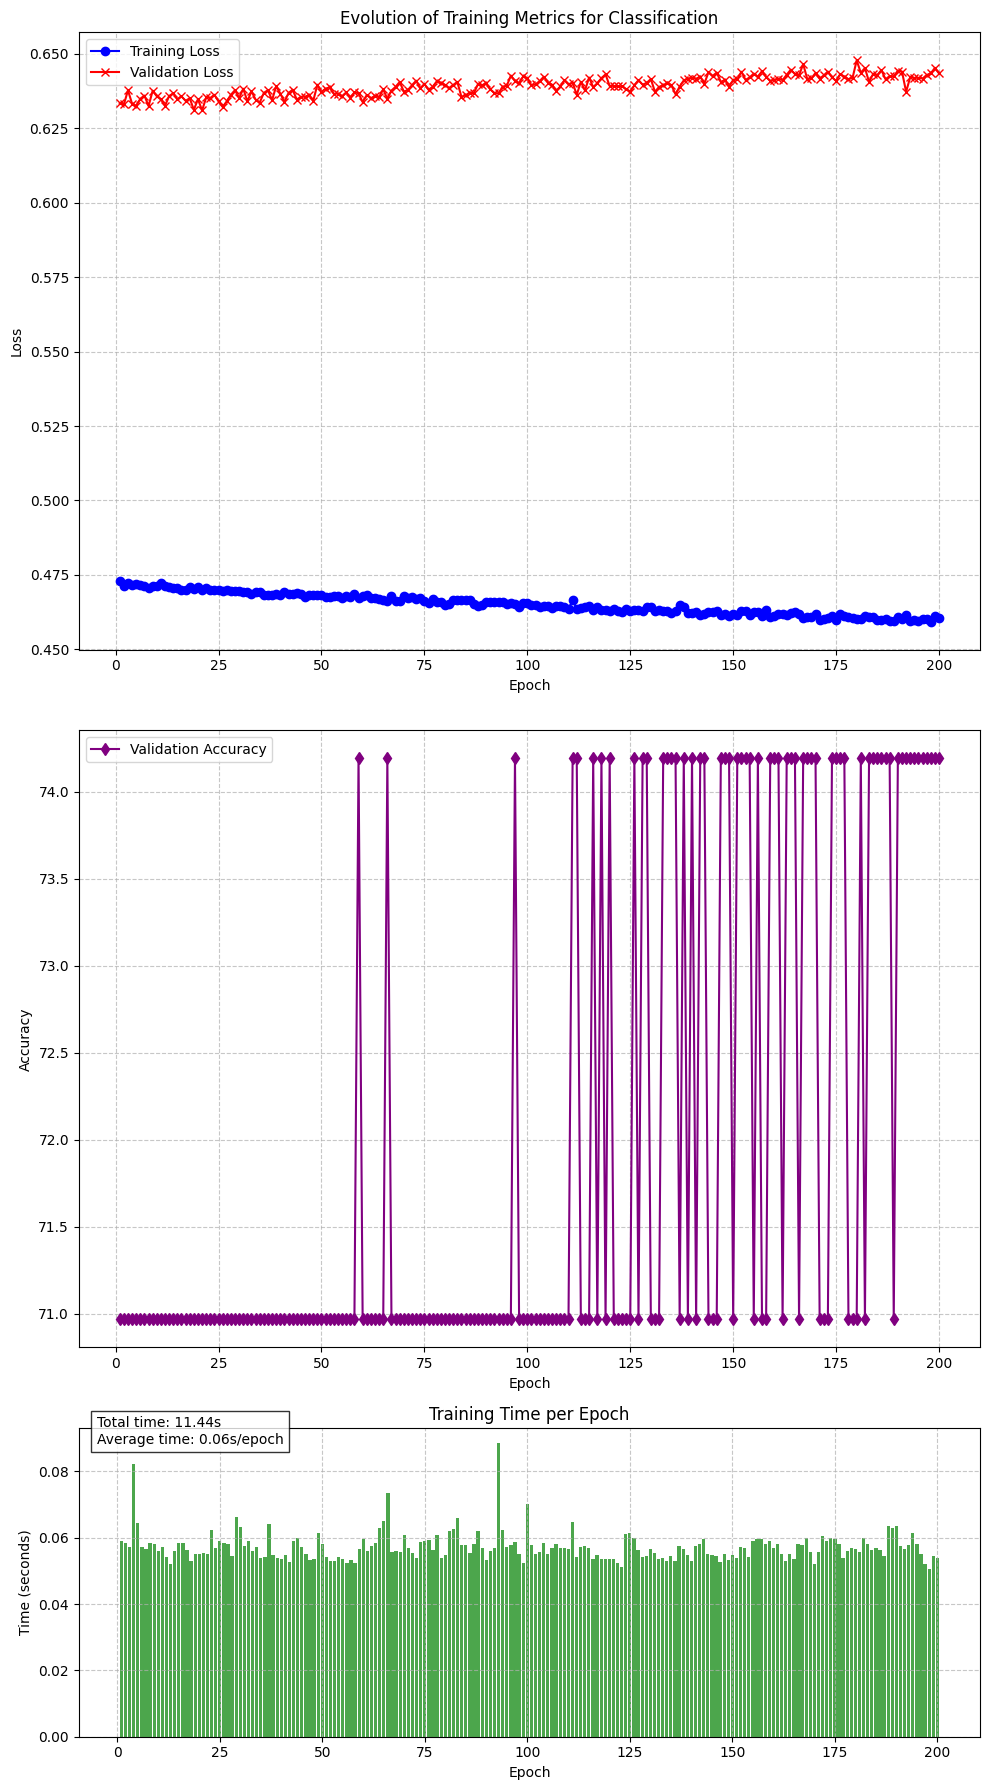

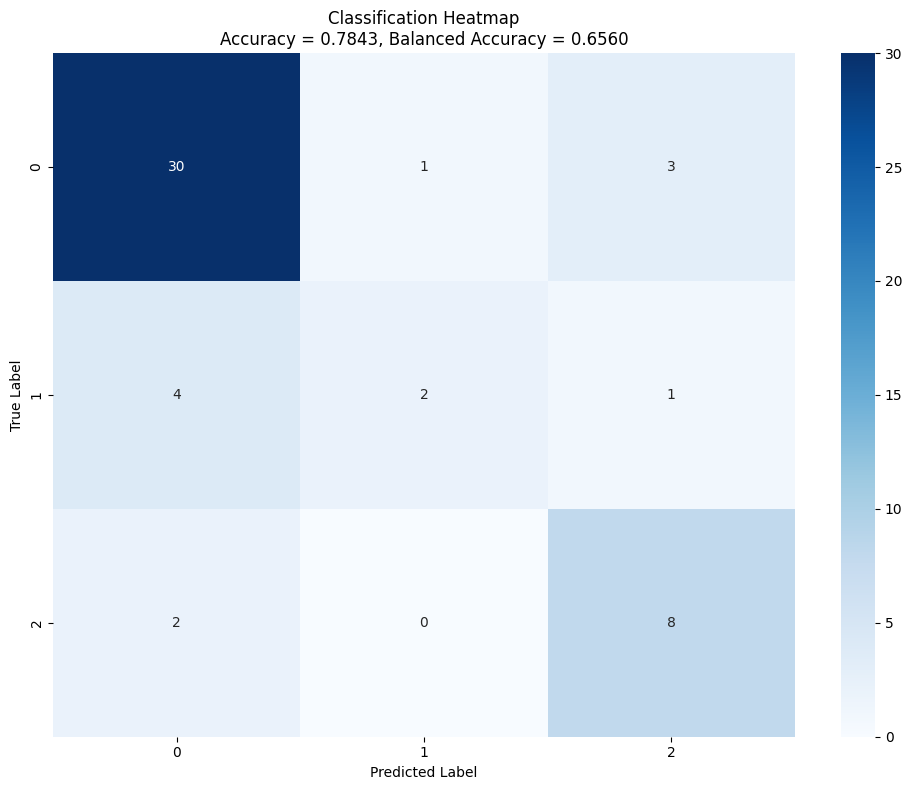

In [36]:

plot_classification_metrics_sequence(
    metrics_history_classification,
    title="Evolution of Training Metrics for Classification")

plot_classification_metrics(all_targets, all_predictions, "Classification Heatmap")


Here the data augmentation seems to increase a little almost all the classification metrics, at the cost of multiplying the learning time by more than 30.

## Partial Conclusion

The data augmentation is not a simple "clear winner". It can be beneficial, at the cost of resources, but it is not obvious, and need testing.